# Photoz with Deep probabilistic neural network

- Keep best models

- author : Sylvie Dagoret-Campagne
- creation : 2023/05/07

### Dependencies & Prerequisites


In [1]:
#@title Import { display-mode: "form" }

from IPython import display

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow import keras
from keras.models import Sequential,Model 
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras import layers
from keras import Input
from keras import initializers

initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)


import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
tfpl = tfp.layers

2023-05-07 20:46:09.345795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import pandas as pd
import os,sys
import h5py
import copy

In [3]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [4]:
def getdataerror(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((
                    mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    mag_err_u_lsst, 
                    mag_err_g_lsst, 
                    mag_err_r_lsst, 
                    mag_err_i_lsst, 
                    mag_err_z_lsst,
                    mag_err_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:6]
    errors = datacut[:,6:-1]
    targets = datacut[:,-1]
    return features,errors,targets    

In [5]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [6]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [7]:
# swap train and test because more example in validation
x_train0,x_train_error0,y_train = getdataerror(hftest)
x_test0,x_test_error0,y_test = getdataerror(hftrain)

In [8]:
NBANDS = x_train0.shape[1]
NSAMPLES = x_train0.shape[0]
NSIM= 1

In [9]:
def simulatesamples(x,ex,nsim=NSIM):
    nsamples = x.shape[0]
    nbands = x.shape[1]
    
    all_samples = np.zeros((nsamples,nbands,nsim))
    for idx in range(nbands):
        mean = x[:,idx]
        sig = ex[:,idx]
        simdata = np.random.normal(mean, sig, (nsim,nsamples))
        all_samples[:,idx,: ] = simdata.T
    return all_samples  

In [10]:
train_data = simulatesamples(x_train0,x_train_error0,NSIM)
test_data = simulatesamples(x_test0,x_test_error0,NSIM)

In [11]:
mean = np.mean(train_data[:,:,0],axis=0)
std  = np.std(train_data[:,:,0],axis=0)

In [12]:
x_train0 = train_data[:,:,0]
x_test0 = test_data[:,:,0]

In [13]:
x_train0_norm = (x_train0-mean)/std
x_test0_norm = (x_test0-mean)/std

In [14]:
all_x_train_norm = []
all_x_test_norm = []
for isim in range(NSIM):
    x_train_norm = (train_data[:,:,isim] - mean)/std
    x_test_norm = (test_data[:,:,isim] - mean)/std
    all_x_train_norm.append(x_train_norm) 
    all_x_test_norm.append(x_test_norm) 

In [15]:
x_train = copy.deepcopy(all_x_train_norm[0])
x_test = copy.deepcopy(all_x_test_norm[0])
y_train = copy.deepcopy(y_train[:,np.newaxis])
y_test = copy.deepcopy(y_test[:,np.newaxis])

## Reference

In [16]:
zspec_ref = np.arange(0,3.25,0.01)

In [17]:
all_ref_indexes = []
for ref in zspec_ref:
    difference_array = np.absolute(y_test[:,0]-ref)
    index = difference_array.argmin()
    #print(ref,y_test[index,0],index)
    all_ref_indexes.append(index) 
all_ref_indexes = np.array(all_ref_indexes)    

In [18]:
x_test_ref = x_test[all_ref_indexes,:] 
y_test_ref = y_test[all_ref_indexes,:] 

## Probability Integral Transform

In [19]:
def ComputePIT(samples,mean,sigma):
    output = stats.norm.cdf(samples,mean,sigma)
    return output

In [20]:
# uniform distribution
u = np.linspace(0,1,100)
uniform_distribution = stats.uniform.pdf(u)

## presentation of results

In [21]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt

In [22]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

In [23]:
def plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15):
    x = np.arange(zmin,zmax,zstep)
    outlier_upper = x + slope*(1+x)
    outlier_lower = x - slope*(1+x)
    return x,outlier_upper,outlier_lower

## Tensorflow callbacks

In [24]:
# Early Stopping Callback
earlystopping_cbk = EarlyStopping(monitor='loss', patience=20, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)
reducelronplateau_cbk = ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=30)

In [25]:
callbacks_list = [reducelronplateau_cbk]

In [26]:
kernel_initializer=initializers.RandomNormal(stddev=0.01),
bias_initializer=initializers.Zeros()

## The model

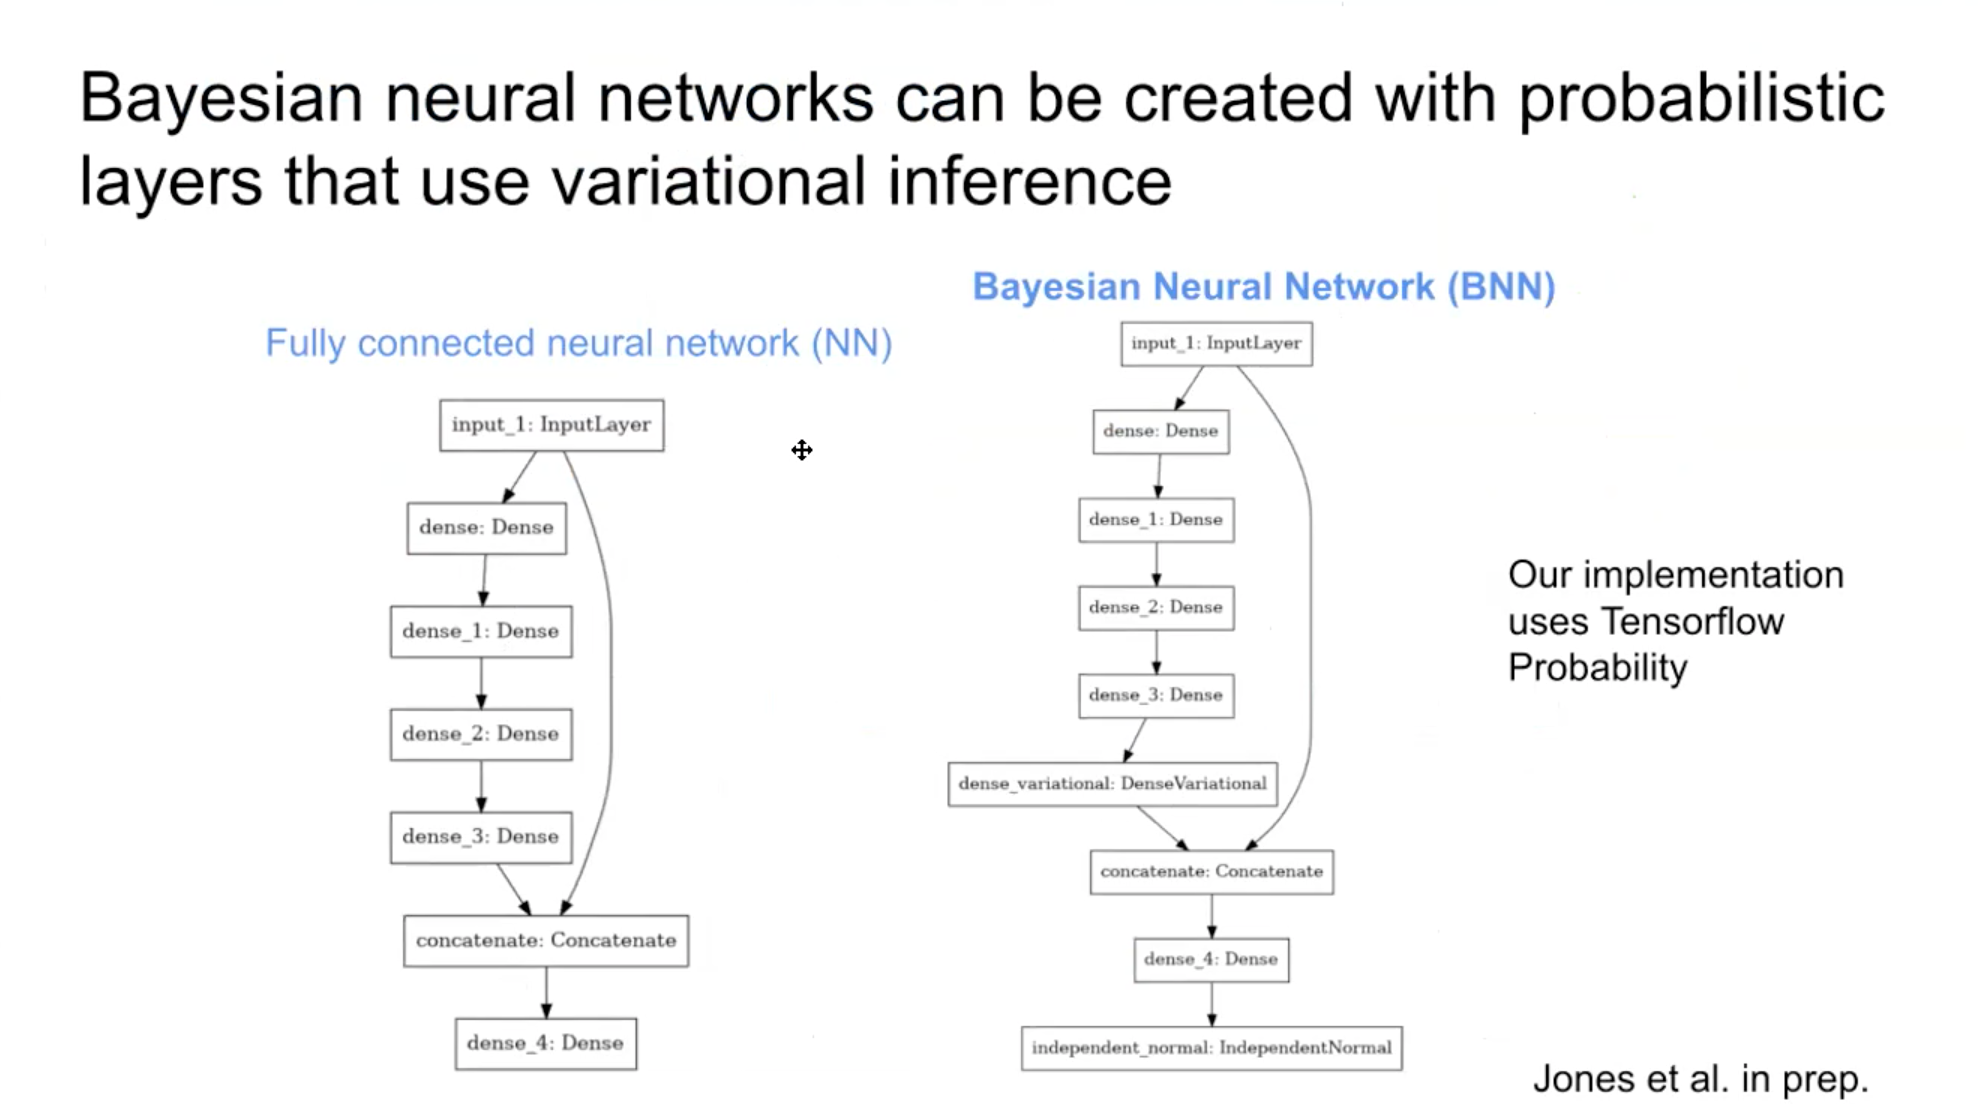

In [27]:
display.Image("Figs/Fig_BauesianNetwork.png")

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [28]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [29]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [30]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Model 4

In [31]:
def get_model_v4(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1',
                           kernel_initializer='random_normal',
                           bias_initializer='zeros')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2',
                          kernel_initializer='random_normal',
                           bias_initializer='zeros')(x)
    x = keras.layers.Dense(12, activation='relu', name='Dense_n4',
                           kernel_initializer='random_normal',
                           bias_initializer='zeros')(x)
    x = keras.layers.Dense(6, activation="relu", name='Dense_n5',
                           kernel_initializer='random_normal',
                           bias_initializer='zeros')(x)
    x = tfp.layers.DenseVariational(6 + 6, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational12')(x)
    

    
    concatenated = keras.layers.concatenate([x,input_tensor],axis=-1)
    #
    x = keras.layers.Dense(2, activation="relu", name='Dense_n6')(concatenated) # need activation to stabilize, unit =2 --> loss 0.67
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty
    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [32]:
n_samples = x_train.shape[0]
model4 = get_model_v4(n_samples)

In [33]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLayer (InputLayer)     [(None, 6)]                  0         []                            
                                                                                                  
 Dense_n1 (Dense)            (None, 12)                   84        ['InputLayer[0][0]']          
                                                                                                  
 Dense_n2 (Dense)            (None, 24)                   312       ['Dense_n1[0][0]']            
                                                                                                  
 Dense_n4 (Dense)            (None, 12)                   300       ['Dense_n2[0][0]']            
                                                                                              

In [34]:
# Fit
history = model4.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 5s 4ms/step - loss: 12886.2559 - val_loss: 1.7021 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 2s 3ms/step - loss: 1.6681 - val_loss: 1.8740 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 2s 3ms/step - loss: 2.1271 - val_loss: 2.1535 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 3s 5ms/step - loss: 1.6924 - val_loss: 3.3559 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 2s 4ms/step - loss: 2.3210 - val_loss: 1.8343 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 2s 3ms/step - loss: 2.2714 - val_loss: 1.9709 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 1s 2ms/step - loss: 3.2655 - val_loss: 1.6500 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 2s 3ms/step - loss: 2.5621 - val_loss: 3.5016 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 2s 4ms/step - loss: 1.9740 - 

Text(0.5, 1.0, 'Model 4 : Loss')

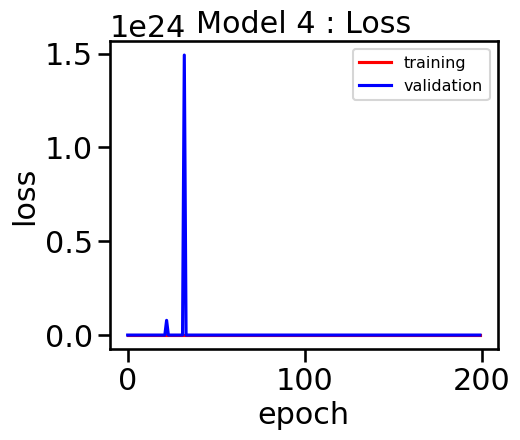

In [35]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 4 : Loss")
#ax.set_yscale('log')

In [36]:
y_pred_train = model4(x_train).sample()
y_pred_test = model4(x_test).sample()

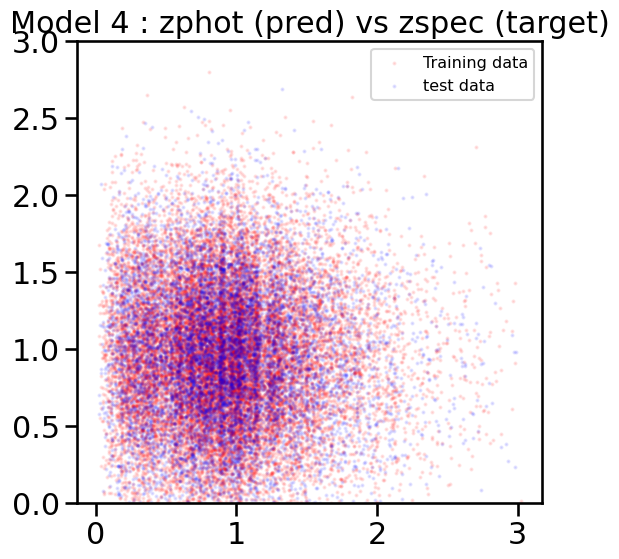

In [37]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 4 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [38]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.3766
Normalized MAD: 0.3442
Delta z >0.15(1+z) outliers: 66.365 percent
Median offset:  0.017 +/-  0.005


In [39]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

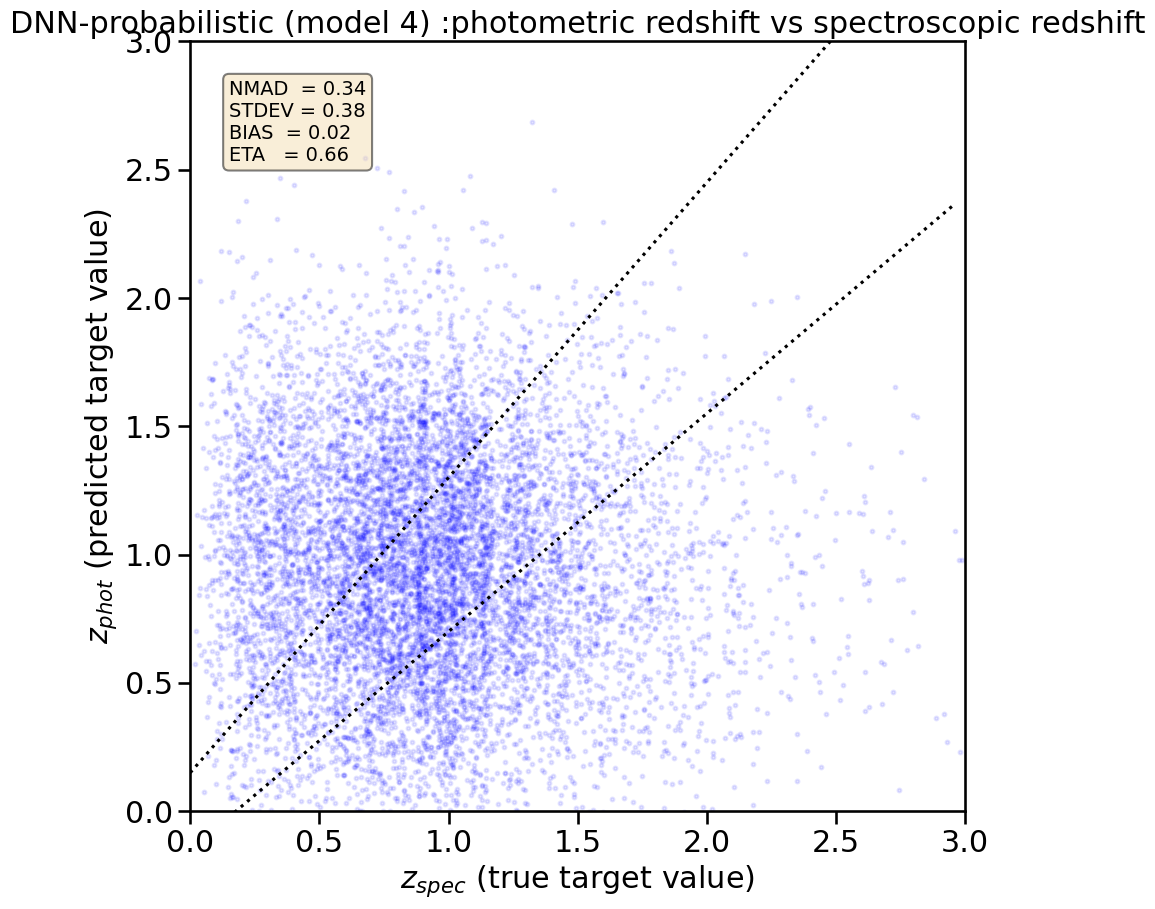

In [40]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 4) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

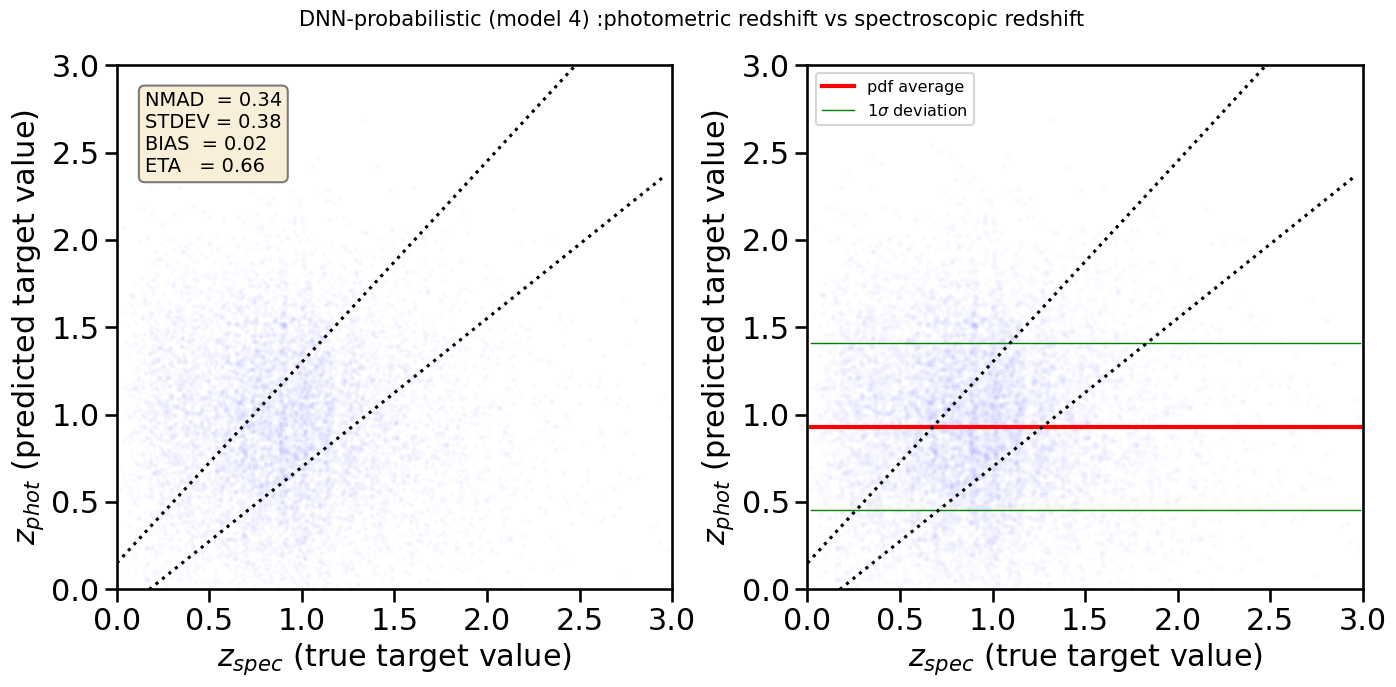

In [41]:
fig=plt.figure(figsize=(14,7))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='o',c="b",s=5,alpha=0.01,label='test data')
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
#ax.set_title("DNN-probabilistic (model 9) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model4(x_test_ref).sample()
y_hat = model4(x_test_ref).mean()
y_sd = model4(x_test_ref).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_test_ref,y_hat,'r-',alpha=1,lw=3,label = 'pdf average')
ax.plot(y_test_ref,y_hat_lower,'g-',alpha=1,lw=1,label = '$1\sigma$ deviation')
ax.plot(y_test_ref,y_hat_upper,'g-',alpha=1,lw=1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.01)
#ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")

ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)
ax.legend()
plt.suptitle("DNN-probabilistic (model 4) :photometric redshift vs spectroscopic redshift")
plt.tight_layout()

In [42]:
y_sample = model4(x_test).sample()
y_hat = model4(x_test).mean()
y_sd = model4(x_test).stddev()
pit = ComputePIT(y_test,y_hat,y_sd)

Text(0.5, 1.0, 'Model 4 : Probability Integral Transform')

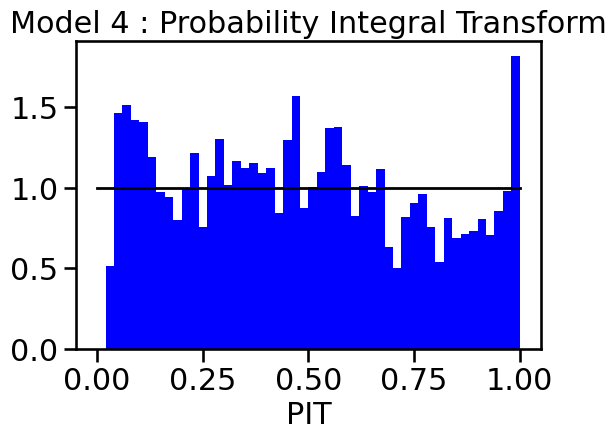

In [43]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(pit.flatten(),bins=50,range=(0,1),facecolor="b",density=True)
ax.plot(u, uniform_distribution, linewidth=2, color="black")
ax.set_xlabel("PIT")
ax.set_title("Model 4 : Probability Integral Transform")

# Model 8

In [44]:
def get_model_v8(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(48, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n4')(x)
    x = keras.layers.Dense(12, activation="relu", name='Dense_n5')(x)
    x = tfp.layers.DenseVariational(12 + 12, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational12')(x)
    #x = keras.layers.Dense(1,  name='Dense_n6')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [45]:
n_samples = x_train.shape[0]
model8 = get_model_v8(n_samples)

In [46]:
model8.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 12)                84        
                                                                 
 Dense_n2 (Dense)            (None, 24)                312       
                                                                 
 Dense_n3 (Dense)            (None, 48)                1200      
                                                                 
 Dense_n4 (Dense)            (None, 24)                1176      
                                                                 
 Dense_n5 (Dense)            (None, 12)                300       
                                                                 
 DenseVariational12 (DenseV  (None, 24)                936 

In [47]:
# Fit
history = model8.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 4s 3ms/step - loss: 2723.0659 - val_loss: 221.7536 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 1s 2ms/step - loss: 34.9210 - val_loss: 369.1170 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 1s 2ms/step - loss: 34.1314 - val_loss: 6.4970 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 1s 2ms/step - loss: 11.5113 - val_loss: 9.1095 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 1s 2ms/step - loss: 7.0263 - val_loss: 3.5634 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 2s 3ms/step - loss: 4.8894 - val_loss: 16.7143 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 2s 3ms/step - loss: 5.2763 - val_loss: 17.7617 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 2s 3ms/step - loss: 3.3639 - val_loss: 2.8359 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 1s 2ms/step - loss: 4

(-1.0, 5.0)

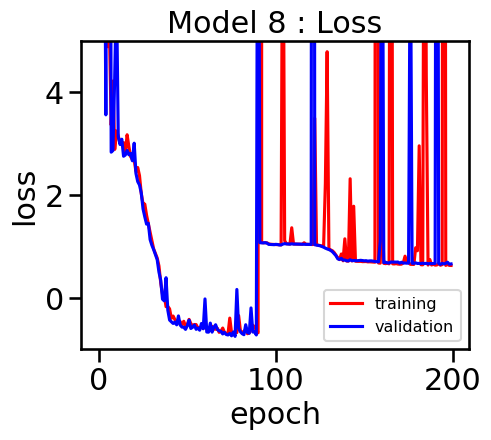

In [48]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 8 : Loss")
ax.set_ylim(-1,5)
#ax.set_yscale('log')

In [49]:
y_pred_train = model8(x_train).sample()
y_pred_test = model8(x_test).sample()

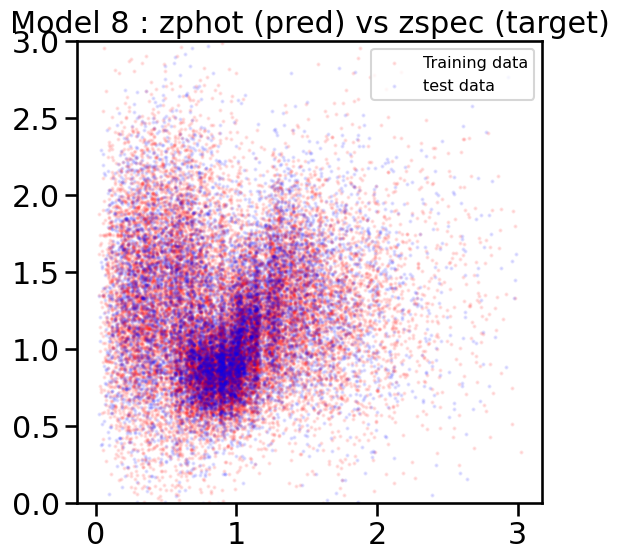

In [50]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 8 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [51]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.4114
Normalized MAD: 0.2506
Delta z >0.15(1+z) outliers: 53.853 percent
Median offset:  0.079 +/-  0.005


In [52]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

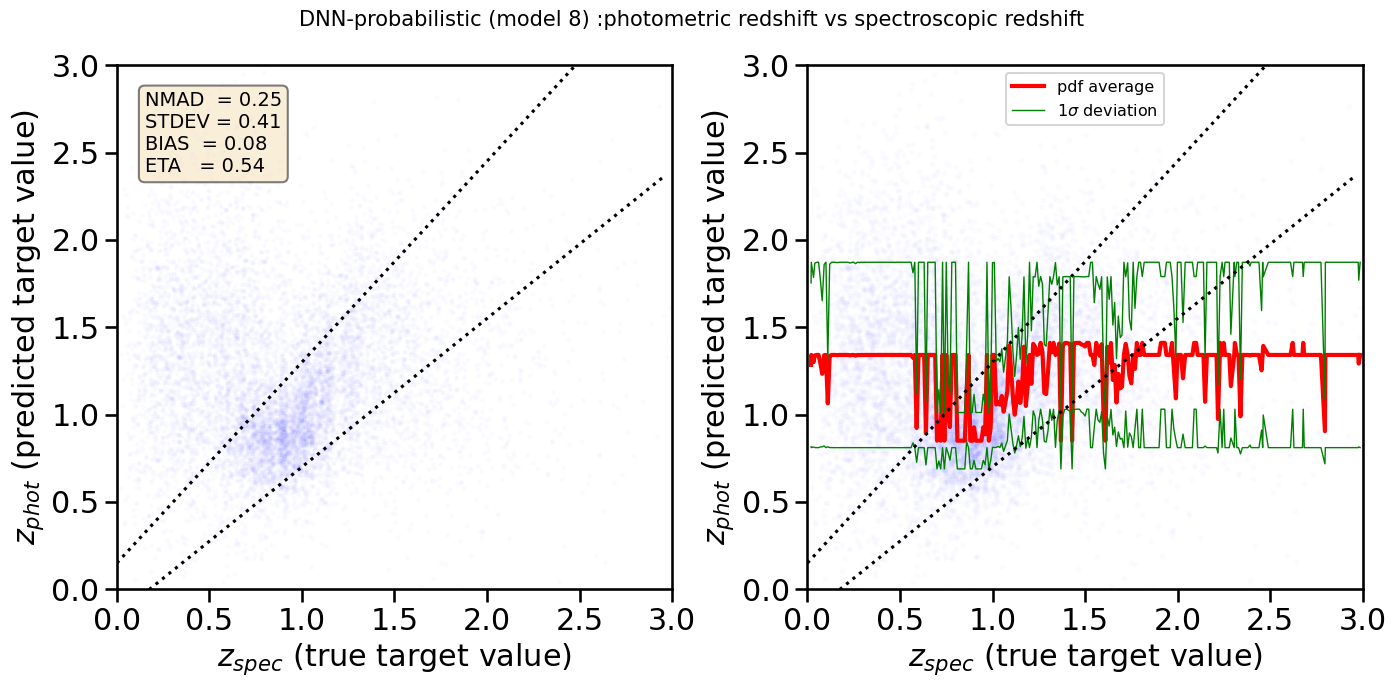

In [53]:
fig=plt.figure(figsize=(14,7))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='o',c="b",s=5,alpha=0.01,label='test data')
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
#ax.set_title("DNN-probabilistic (model 8) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model8(x_test_ref).sample()
y_hat = model8(x_test_ref).mean()
y_sd = model8(x_test_ref).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_test_ref,y_hat,'r-',alpha=1,lw=3,label = 'pdf average')
ax.plot(y_test_ref,y_hat_lower,'g-',alpha=1,lw=1,label = '$1\sigma$ deviation')
ax.plot(y_test_ref,y_hat_upper,'g-',alpha=1,lw=1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.01)
#ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")

ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)
ax.legend()
plt.suptitle("DNN-probabilistic (model 8) :photometric redshift vs spectroscopic redshift")
plt.tight_layout()

In [54]:
y_sample = model8(x_test).sample()
y_hat = model8(x_test).mean()
y_sd = model8(x_test).stddev()
pit = ComputePIT(y_test,y_hat,y_sd)

Text(0.5, 1.0, 'Model 8 : Probability Integral Transform')

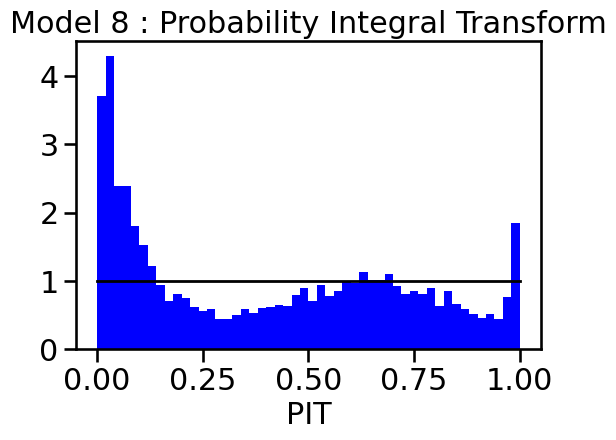

In [55]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(pit.flatten(),bins=50,range=(0,1),facecolor="b",density=True)
ax.plot(u, uniform_distribution, linewidth=2, color="black")
ax.set_xlabel("PIT")
ax.set_title("Model 8 : Probability Integral Transform")

# Model 9

In [56]:
def get_model_v9(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2')(x)
    #x = keras.layers.Dense(48, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n4')(x)
    x = keras.layers.Dense(12, activation="relu", name='Dense_n5')(x)
    x = tfp.layers.DenseVariational(12 + 12, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational12')(x)
    #x = tfp.layers.DenseVariational(6 + 6, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational6')(x)
    
    #x = keras.layers.Dense(1,  name='Dense_n6')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [57]:
n_samples = x_train.shape[0]
model9 = get_model_v9(n_samples)

In [58]:
model9.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 12)                84        
                                                                 
 Dense_n2 (Dense)            (None, 24)                312       
                                                                 
 Dense_n4 (Dense)            (None, 24)                600       
                                                                 
 Dense_n5 (Dense)            (None, 12)                300       
                                                                 
 DenseVariational12 (DenseV  (None, 24)                936       
 ariational)                                                     
                                                           

In [59]:
# Fit
history = model9.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 4s 3ms/step - loss: 29954.6270 - val_loss: 98.2972 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 1s 2ms/step - loss: 92.7725 - val_loss: 31.6773 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 1s 2ms/step - loss: 26.7326 - val_loss: 68.5928 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 1s 2ms/step - loss: 56.2314 - val_loss: 95486.9219 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 2s 3ms/step - loss: 361.8012 - val_loss: 32.6367 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 2s 3ms/step - loss: 28.0874 - val_loss: 4.9347 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 2s 3ms/step - loss: 31.9583 - val_loss: 8.7893 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 1s 2ms/step - loss: 33.7864 - val_loss: 29.8232 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 1s 2ms/step 

(-1.0, 5.0)

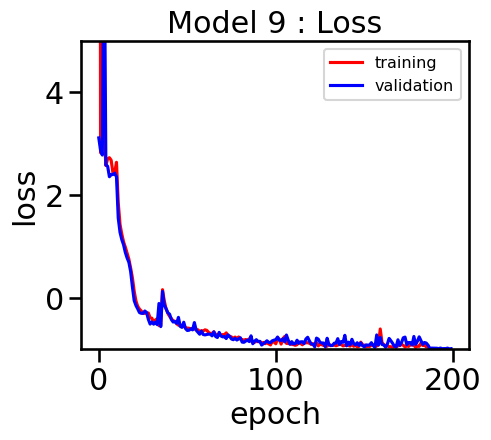

In [79]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 9 : Loss")
ax.set_ylim(-1,5)
#ax.set_yscale('log')

In [61]:
y_pred_train = model9(x_train).sample()
y_pred_test = model9(x_test).sample()

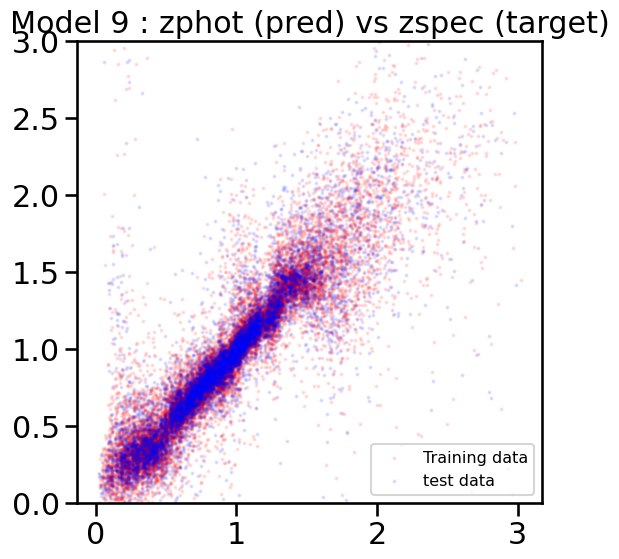

In [62]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 9 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [63]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.1327
Normalized MAD: 0.0534
Delta z >0.15(1+z) outliers: 10.840 percent
Median offset: -0.001 +/-  0.002


In [64]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

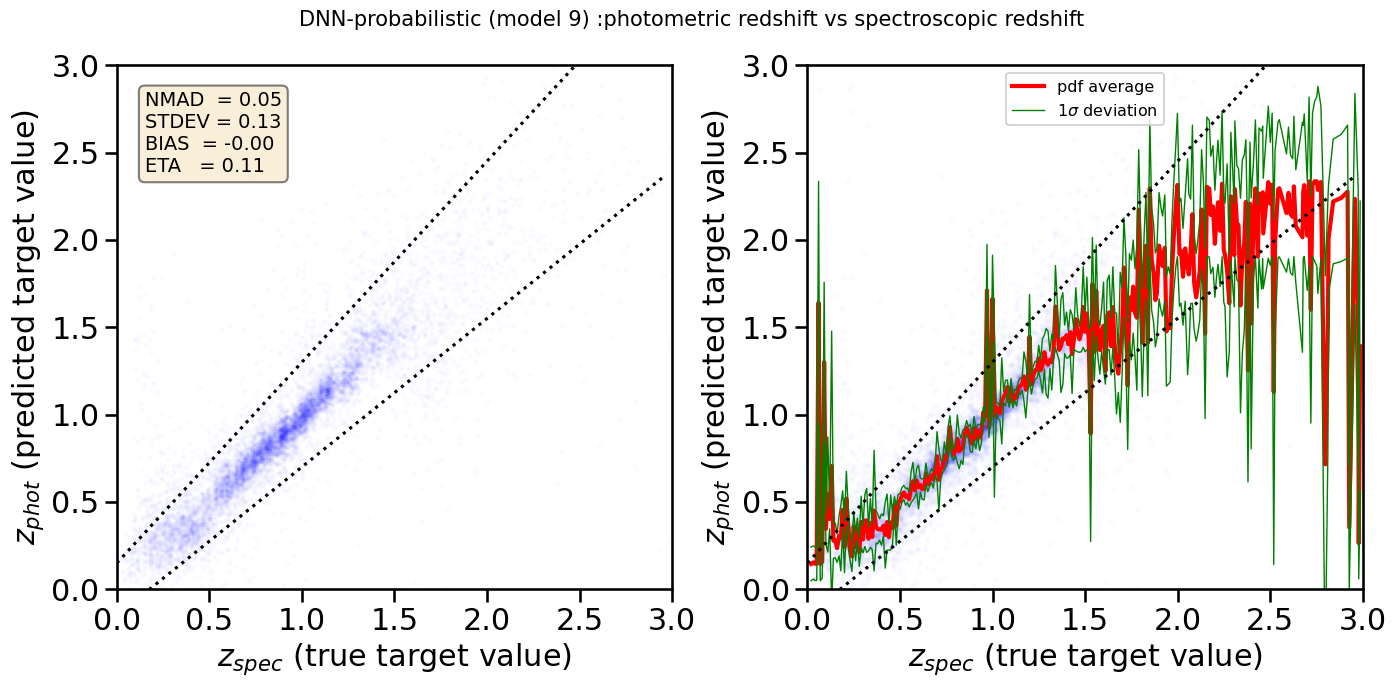

In [65]:
fig=plt.figure(figsize=(14,7))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='o',c="b",s=5,alpha=0.01,label='test data')
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
#ax.set_title("DNN-probabilistic (model 9) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model9(x_test_ref).sample()
y_hat = model9(x_test_ref).mean()
y_sd = model9(x_test_ref).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_test_ref,y_hat,'r-',alpha=1,lw=3,label = 'pdf average')
ax.plot(y_test_ref,y_hat_lower,'g-',alpha=1,lw=1,label = '$1\sigma$ deviation')
ax.plot(y_test_ref,y_hat_upper,'g-',alpha=1,lw=1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.01)
#ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")

ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)
ax.legend()
plt.suptitle("DNN-probabilistic (model 9) :photometric redshift vs spectroscopic redshift")
plt.tight_layout()

In [66]:
y_sample = model9(x_test).sample()
y_hat = model9(x_test).mean()
y_sd = model9(x_test).stddev()
pit = ComputePIT(y_test,y_hat,y_sd)

Text(0.5, 1.0, 'Model 9 : Probability Integral Transform')

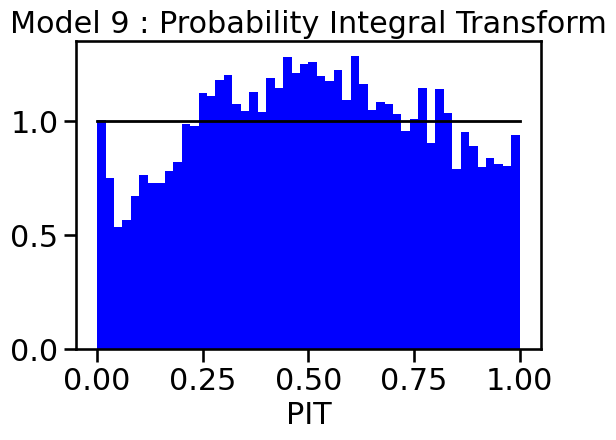

In [67]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(pit.flatten(),bins=50,range=(0,1),facecolor="b",density=True)
ax.plot(u, uniform_distribution, linewidth=2, color="black")
ax.set_xlabel("PIT")
ax.set_title("Model 9 : Probability Integral Transform")

# Model 10

In [68]:
def get_model_v10(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2')(x)
    #x = keras.layers.Dense(48, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(12, activation='relu', name='Dense_n4')(x)
    x = keras.layers.Dense(6, activation="relu", name='Dense_n5')(x)
    x = tfp.layers.DenseVariational(6 + 6, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational12')(x)
    #x = tfp.layers.DenseVariational(6 + 6, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational6')(x)
    
    #x = keras.layers.Dense(1,  name='Dense_n6')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [69]:
n_samples = x_train.shape[0]
model10 = get_model_v10(n_samples)

In [80]:
model10.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 12)                84        
                                                                 
 Dense_n2 (Dense)            (None, 24)                312       
                                                                 
 Dense_n4 (Dense)            (None, 12)                300       
                                                                 
 Dense_n5 (Dense)            (None, 6)                 78        
                                                                 
 DenseVariational12 (DenseV  (None, 12)                252       
 ariational)                                                     
                                                           

In [70]:
# Fit
history = model10.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 4s 3ms/step - loss: 33.3170 - val_loss: 3.1142 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 2s 3ms/step - loss: 2.8263 - val_loss: 2.8724 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 1s 2ms/step - loss: 4.6619 - val_loss: 2.7798 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 1s 2ms/step - loss: 3.2308 - val_loss: 7.6380 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 1s 2ms/step - loss: 2.5754 - val_loss: 2.5879 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 1s 2ms/step - loss: 2.7087 - val_loss: 2.5625 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 1s 2ms/step - loss: 2.7285 - val_loss: 2.3574 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 1s 2ms/step - loss: 2.6793 - val_loss: 2.3969 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 1s 2ms/step - loss: 2.4293 - val

(-1.0, 5.0)

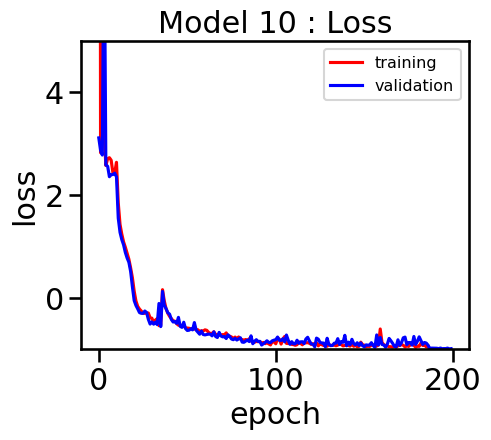

In [71]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 10 : Loss")
ax.set_ylim(-1,5)
#ax.set_yscale('log')

In [72]:
y_pred_train = model10(x_train).sample()
y_pred_test = model10(x_test).sample()

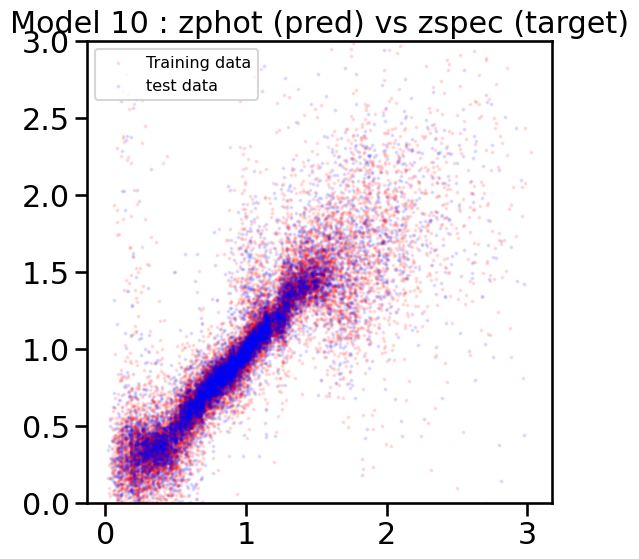

In [73]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 10 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [74]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.1317
Normalized MAD: 0.0507
Delta z >0.15(1+z) outliers: 11.755 percent
Median offset: -0.003 +/-  0.002


In [75]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

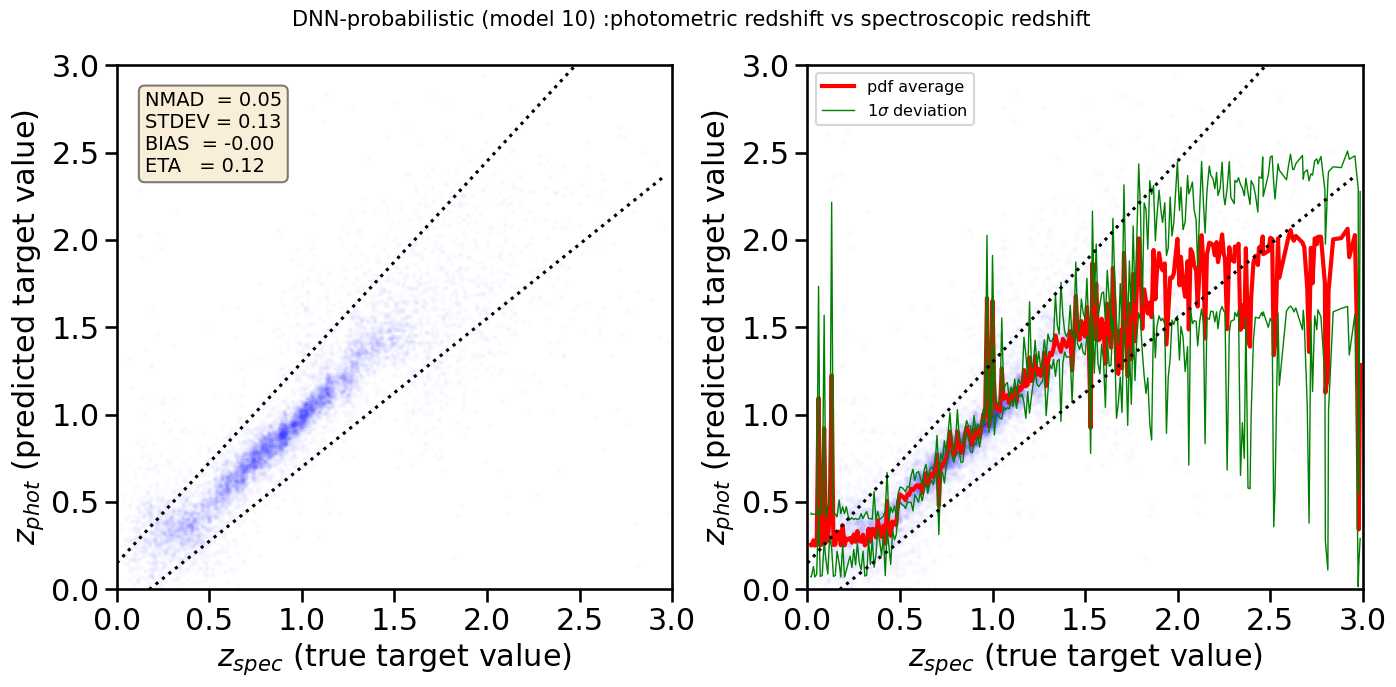

In [76]:
fig=plt.figure(figsize=(14,7))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='o',c="b",s=5,alpha=0.01,label='test data')
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
#ax.set_title("DNN-probabilistic (model 9) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model10(x_test_ref).sample()
y_hat = model10(x_test_ref).mean()
y_sd = model10(x_test_ref).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_test_ref,y_hat,'r-',alpha=1,lw=3,label = 'pdf average')
ax.plot(y_test_ref,y_hat_lower,'g-',alpha=1,lw=1,label = '$1\sigma$ deviation')
ax.plot(y_test_ref,y_hat_upper,'g-',alpha=1,lw=1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.01)
#ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")

ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)
ax.legend()
plt.suptitle("DNN-probabilistic (model 10) :photometric redshift vs spectroscopic redshift")
plt.tight_layout()

In [77]:
y_sample = model10(x_test).sample()
y_hat = model10(x_test).mean()
y_sd = model10(x_test).stddev()
pit = ComputePIT(y_test,y_hat,y_sd)

Text(0.5, 1.0, 'Model 10 : Probability Integral Transform')

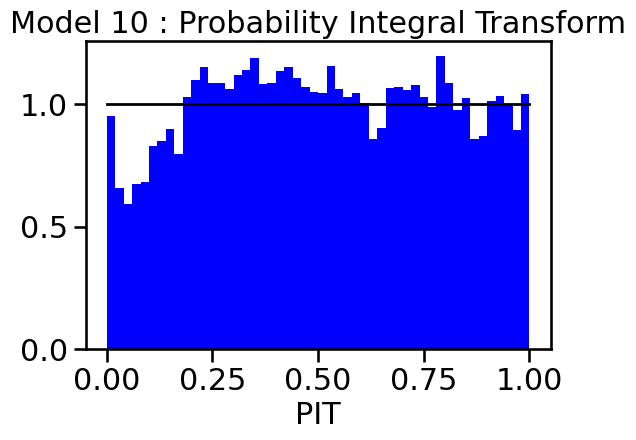

In [78]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(pit.flatten(),bins=50,range=(0,1),facecolor="b",density=True)
ax.plot(u, uniform_distribution, linewidth=2, color="black")
ax.set_xlabel("PIT")
ax.set_title("Model 10 : Probability Integral Transform")